# Finding RNAfish spots in 256x256 images using Unet, Conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils

In [2]:
data='/home/ubuntu/Neuromast/'

# Get data

Load data from file

In [3]:
shp=[16,128,128,9]

In [4]:
both=utils.get_raw_float_image(data+'Training_Binned_Rot.raw',shp)

train_data=both[:,:,:,:,[1]]/65535.0
train_truth=both[:,:,:,:,[4]]/255.0

mean=np.mean(train_data)
std=np.std(train_data)

train_data=(train_data-mean)/std+0.5


validation=utils.get_raw_float_image(data+'Validation.raw',shp)

validation_data=validation[:,:,:,:,[1]]/65535.0
validation_truth=validation[:,:,:,:,[4]]/255.0


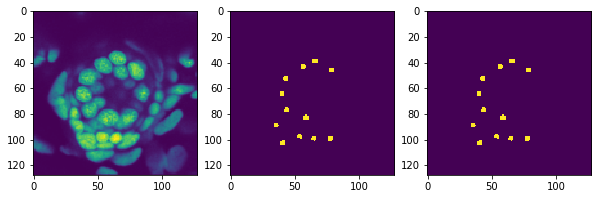

In [20]:
h=15
utils.plot_3x1(train_data[0,h,:,:,0], train_truth[0,h,:,:,0], train_truth[0,h,:,:,0])

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [21]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 16, 128,128,1])
y=tf.placeholder(dtype=tf.float32, shape=[None, 16, 128,128,1])

lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')
dr=tf.placeholder(dtype=tf.float32, shape=[], name='dropout_rate')

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

xr=x
yr=y

base_scaler=32

#Going down
A1=utils.leaky_relu(tf.layers.conv3d(xr, base_scaler, [3,5,5], padding='SAME', kernel_regularizer=regularizer))
A2=utils.leaky_relu(tf.layers.conv3d(A1, base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

B0=tf.nn.max_pool3d(A2, ksize=[1,1,2,2,1], strides=[1,1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv3d(B0, 2*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
B2=utils.leaky_relu(tf.layers.conv3d(B1, 2*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

C0=tf.nn.max_pool3d(B2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv3d(C0, 4*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
C2=utils.leaky_relu(tf.layers.conv3d(C1, 4*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

D0=tf.nn.max_pool3d(C2, ksize=[1,1,2,2,1], strides=[1,1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv3d(D0, 8*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
D2=utils.leaky_relu(tf.layers.conv3d(D1, 8*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

E0=tf.nn.max_pool3d(D2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.layers.conv3d(E0, 16*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
E2=utils.leaky_relu(tf.layers.conv3d(E1, 16*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

#Coming up
DD0=tf.layers.conv3d_transpose(E2, 8*base_scaler, kernel_size=[3,3,3], strides=[2,2, 2], padding='SAME')
DD1=tf.concat(axis=4, values=[DD0,D2])
DD2=utils.leaky_relu(tf.layers.conv3d(DD1, 8*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
DD3=utils.leaky_relu(tf.layers.conv3d(DD2, 8*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

CC0=tf.layers.conv3d_transpose(DD3, 4*base_scaler, kernel_size=[3,3,3], strides=[1,2, 2], padding='SAME')
CC1=tf.concat(axis=4, values=[CC0,C2])
CC2=utils.leaky_relu(tf.layers.conv3d(CC1, 4*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
CC3=utils.leaky_relu(tf.layers.conv3d(CC2, 4*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

BB0=tf.layers.conv3d_transpose(CC3, 2*base_scaler, kernel_size=[3,3,3], strides=[2,2, 2], padding='SAME')
#BB0=tf.contrib.layers.conv2d_transpose(C2, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=4, values=[BB0,B2])
BB2=utils.leaky_relu(tf.layers.conv3d(BB1, 2*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
BB3=utils.leaky_relu(tf.layers.conv3d(BB2, 2*base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

AA0=tf.layers.conv3d_transpose(BB3, base_scaler, kernel_size=[3,3,3], strides=[1,2, 2], padding='SAME')
AA1=tf.concat(axis=4, values=[AA0,A2])
AA2=utils.leaky_relu(tf.layers.conv3d(AA1, base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))
AA3=utils.leaky_relu(tf.layers.conv3d(AA2, base_scaler, [3,3,3], padding='SAME', kernel_regularizer=regularizer))

logits=utils.leaky_relu(tf.layers.conv3d(AA3, 1, [1,1,1], padding='SAME', kernel_regularizer=regularizer))
probs=tf.tanh(logits, name='probabilities')

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
#OutError, MaskError=tf.split(LSQ, [1,1], 3)
#loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
loss=tf.reduce_mean(LSQ, name='error')
l2_loss = tf.losses.get_regularization_loss()
#loss=loss+l2_loss/1000

train_op=tf.train.AdamOptimizer(learning_rate=lr, name='trainer').minimize(loss)

tf.summary.scalar('loss', loss)
#tf.summary.image('input', x, 10)
#tf.summary.image('standard', y, 10)
#tf.summary.image('processed', probs, 10)


merge = tf.summary.merge_all()

# Training on easy set

0
Training loss:  0.004831969
(4, 16, 128, 128, 1)
Validation loss:  0.0067178025


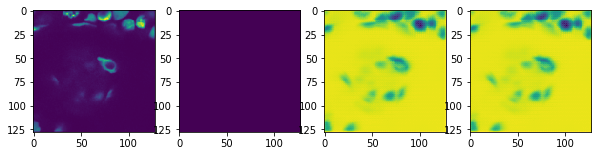

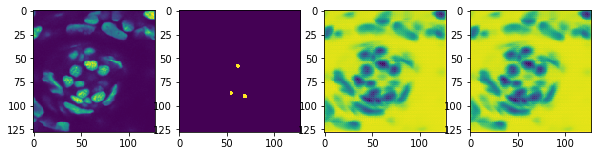

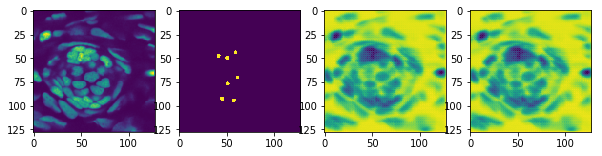

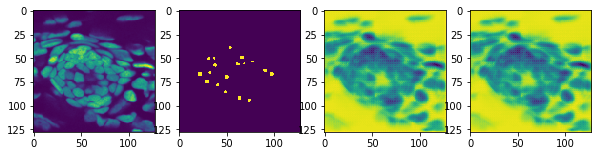

In [ ]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=52)
#train_writer = tf.summary.FileWriter('./logs/1/train ', sess.graph)
test_writer = tf.summary.FileWriter('./logs/6/test ')


learning_rates=[0.0015, 0.001]
learning_rate_steps=[1000, 2400]
current_step=0
for lrate, lrs in zip(learning_rates, learning_rate_steps):
    for i in range(current_step, lrs):
        idx=np.random.choice(train_data.shape[0], replace=False, size=[20])
        cur_train=train_data[idx,:,:,:]
        cur_truth=train_truth[idx,:,:]
        _, results, losses=sess.run([train_op,  probs, loss], feed_dict={x:cur_train, y:cur_truth, lr:lrate})
        #train_writer.add_summary(summary, i)
        if (i%100==0):
            print(i)
            print("Training loss: ",losses)
            #idx=np.random.choice(validation_data.shape[0], replace=False, size=[50])
            idx=range(0,4, 1)
            sub_validation_data=validation_data[idx, :,:,:]
            sub_validation_truth=validation_truth[idx, :,:]
            summary, results, losses, a,c,cc=sess.run([merge, probs, loss, A1,C2,CC2], feed_dict={x:sub_validation_data, y:sub_validation_truth})
            test_writer.add_summary(summary, i)
            print(results.shape)
            print("Validation loss: ",losses)
            for ti in range (0,4):
                utils.plot_4x1(sub_validation_data[ti,0,:,:,0], sub_validation_truth[ti,0,:,:,0], results[ti,0,:,:,0], results[ti,0,:,:,0])
                plt.show()
            saver.save(sess, data+'Models/Model'+str(i))
    current_step=lrs

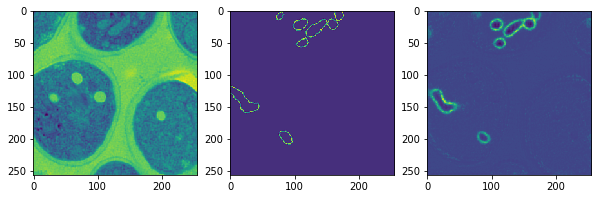

In [110]:
idx=np.random.choice(train_data.shape[0], replace=False, size=[50])
cur_train=train_data[idx,:,:,:]
cur_truth=train_truth[idx,:,:]
results, losses=sess.run([probs, loss], feed_dict={x:cur_train, y:cur_truth, lr:lrate})

ids=4
utils.plot_3x1(cur_train[ids,:,:,0], cur_truth[ids,:,:,0], results[ids,:,:,0])

# Process new datafiles using trained network

Load the network that works best

In [11]:
saver = tf.train.Saver()
sess=tf.Session()
sess.run(tf.global_variables_initializer())

data_model=data+'NewModels/Model2300'
saver.restore(sess,data_model)

INFO:tensorflow:Restoring parameters from /media/smc/YeastEM/NewModels/Model2300


Function for processing a file

In [14]:
mean=143.0/255.0
std=25.0/255.0

In [15]:
def process_file(sess, file_name):
    file_data=utils.get_raw_float_image(file_name, [1,256,256,1])
    file_data=np.reshape(file_data, [file_data.shape[0], 256, 256, 1])
    true_test2_data=file_data[:,:,:,[0]]/255.0
    true_test2_truth=file_data[:,:,:,[0]]
    true_test2_truth[:,:,:,0]=true_test2_truth[:,:,:,0]/32000.0
    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    #true_test2_data=true_test2_data/np.std(true_test2_data)*0.02
    #true_test2_data=true_test2_data-np.mean(true_test2_data)+0.55
    true_test2_data=(true_test2_data-mean)/std+0.5

    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    
    num_images=true_test2_data.shape[0]
    output=np.zeros([num_images,256,256,3])
    process_batch_size=50
    print('Starting')
    for t in range(0,num_images,process_batch_size):
        endrng=np.min((t+process_batch_size,num_images))
        sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
        sub_validation_truth=true_test2_truth[t:(t+process_batch_size), :,:]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        output[t:(t+process_batch_size),:,:,0]=sub_validation_data[:,:,:,0]
        output[t:(t+process_batch_size),:,:,1]=results[:,:,:,0]
        output[t:(t+process_batch_size),:,:,2]=results[:,:,:,0]
    print('Done')
    output=np.swapaxes(np.swapaxes(output,3,2),2,1)
    np.place(output, output<0, 0)
    (output*255.0).astype(np.uint8).tofile(file_name[0:-4]+'_outputb.raw')
    print(file_name[0:-4]+'_output.raw')
    return output


In [16]:
output=process_file(sess,data+'All.raw')

0.291259
0.427067
2.97083
-0.86366
Starting
Done
/media/smc/YeastEM/All_output.raw


In [70]:
output.shape

(11583, 3, 256, 256)